In [4]:
import torch
from torch.utils.data import DataLoader, RandomSampler, Subset
from torch import nn
import numpy as np
import sys
from utils import data
from utils.data import COCODataset, getLabelMap
import matplotlib.pyplot as plt
import math
use_gpu = True

#### MTL Architecture

In [5]:
class MTLUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=60):
        super(MTLUNet, self).__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Encoding #
        self.enc0 = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5))
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5))
        self.enc2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5))
        self.enc3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5))
        
        # Shared Base #
        self.shared_base = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+512, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(1024),
                                         nn.Dropout(p=0.5))
        
        # Task-specific Bases
        self.seg_base = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(1024),
                                      nn.Dropout(p=0.5),
                                      nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(512),
                                      nn.Dropout(p=0.5))
        self.class_base = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.Dropout(p=0.5))    
        
        # Task 1: Segmentation #
        self.seg3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0))
        self.seg2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+512, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0))
        self.seg1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+256, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0))
        self.seg0 = nn.Sequential(nn.Conv2d(in_channels=num_channels+128, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1))
        
        # Task 2: Classification #
        self.class3 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(1024),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(512),
                                    nn.Dropout(p=0.5))
        self.class2 = nn.Sequential(nn.Conv2d(in_channels=1024+512, out_channels=256, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Dropout(p=0.5))
        self.class1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(p=0.5))
        self.class0 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        
    def forward(self, X):
        # Encoding
        
        # Lvl 0
        #print(f'X shape, X_0 input: {X.shape}')
        X_0 = self.enc0(X)
        #print(f'X_0 shape: {X_0.shape}')
        X_0 = torch.cat((X, X_0), dim=1)  # dense connection
        #print(f'X_0 shape: {X_0.shape}')
        X_0_mp = self.maxpool(X_0)
        #print(f'X_0_mp, X_1 input shape: {X_0_mp.shape}')
        
        # Lvl 1
        X_1 = self.enc1(X_0_mp)
        X_1 = torch.cat((X_0_mp, X_1), dim=1)  # dense connection
        X_1_mp = self.maxpool(X_1)
        #print(f'X_1_mp, X_2 input shape: {X_1_mp.shape}')
        
        # Lvl 2
        X_2 = self.enc2(X_1_mp)
        X_2 = torch.cat((X_1_mp, X_2), dim=1)  # dense connection
        X_2_mp = self.maxpool(X_2)
        #print(f'X_2_mp, X_3 input shape: {X_2_mp.shape}')
        
        # Lvl 3
        X_3 = self.enc3(X_2_mp)
        X_3 = torch.cat((X_2_mp, X_3), dim=1)  # dense connection
        X_3_mp = self.maxpool(X_3)
        #print(f'X_3_mp, shared_base input shape: {X_3_mp.shape}')
        
        # Base
        shared_base = self.shared_base(X_3_mp)
        #print(f'shared_base output shape: {shared_base.shape}')
        
        # Task 1: Segmentation
        seg_output = self.seg_base(shared_base)
        #print(f'seg_base output shape: {seg_output.shape}')
        seg_output = torch.cat((X_3, seg_output), dim=1)  # skip connection
        #print(f'seg3 input shape: {seg_output.shape}')
        seg_output = self.seg3(seg_output)
        #print(f'seg3 output shape: {seg_output.shape}')
        
        seg_output = torch.cat((X_2, seg_output), dim=1)  # skip connection
        seg_output = self.seg2(seg_output)
        #print(f'seg2 output shape: {seg_output.shape}')
        
        seg_output = torch.cat((X_1, seg_output), dim=1)  # skip connection
        seg_output = self.seg1(seg_output)
        #print(f'seg1 output shape: {seg_output.shape}')
        
        seg_output = torch.cat((X_0, seg_output), dim=1)  # skip connection
        #print(f'seg0 input shape: {seg_output.shape}')
        seg_output = self.seg0(seg_output)
        #print(f'seg0 output shape: {seg_output.shape}')
        
        # Task 2: Classification
        #print(f'class3 input shape: {shared_base.shape}')
        class_output = self.class3(shared_base)
        class_output = torch.cat((shared_base, class_output), dim=1)  # dense connection
        #print(f'class3 output shape: {class_output.shape}')
        class_output = self.class2(class_output)
        #print(f'class2 output shape: {class_output.shape}')
        class_output = self.class1(class_output)
        #print(f'class1 output shape: {class_output.shape}')
        class_output = self.class0(class_output)
        #print(f'class0 output shape: {class_output.shape}')
        
        return seg_output, class_output
        

In [3]:
class SegOnlyUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=60):
        super(SegOnlyUNet, self).__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Encoding #
        self.enc0 = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5))
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5))
        self.enc2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5))
        self.enc3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5))
        
        # Shared Base #
        self.shared_base = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+512, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(1024),
                                         nn.Dropout(p=0.5))
        
        # Task-specific Bases
        self.seg_base = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(1024),
                                      nn.Dropout(p=0.5),
                                      nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(512),
                                      nn.Dropout(p=0.5))
        
        # Task 1: Segmentation #
        self.seg3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0))
        self.seg2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+512, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0))
        self.seg1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+256, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0))
        self.seg0 = nn.Sequential(nn.Conv2d(in_channels=num_channels+128, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1))
        
    def forward(self, X):
        # Encoding
        
        # Lvl 0
        X_0 = self.enc0(X)
        X_0 = torch.cat((X, X_0), dim=1)  # dense connection
        X_0_mp = self.maxpool(X_0)
        
        # Lvl 1
        X_1 = self.enc1(X_0_mp)
        X_1 = torch.cat((X_0_mp, X_1), dim=1)  # dense connection
        X_1_mp = self.maxpool(X_1)
        
        # Lvl 2
        X_2 = self.enc2(X_1_mp)
        X_2 = torch.cat((X_1_mp, X_2), dim=1)  # dense connection
        X_2_mp = self.maxpool(X_2)
        
        # Lvl 3
        X_3 = self.enc3(X_2_mp)
        X_3 = torch.cat((X_2_mp, X_3), dim=1)  # dense connection
        X_3_mp = self.maxpool(X_3)
        
        # Base
        shared_base = self.shared_base(X_3_mp)
        
        # Task 1: Segmentation
        seg_output = self.seg_base(shared_base)
        seg_output = torch.cat((X_3, seg_output), dim=1)  # skip connection
        seg_output = self.seg3(seg_output)
        
        seg_output = torch.cat((X_2, seg_output), dim=1)  # skip connection
        seg_output = self.seg2(seg_output)
        
        seg_output = torch.cat((X_1, seg_output), dim=1)  # skip connection
        seg_output = self.seg1(seg_output)
        
        seg_output = torch.cat((X_0, seg_output), dim=1)  # skip connection
        seg_output = self.seg0(seg_output)
        
        return seg_output
        

In [4]:
class ClassOnlyUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=60):
        super(ClassOnlyUNet, self).__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Encoding #
        self.enc0 = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5))
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5))
        self.enc2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5))
        self.enc3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5))
        
        # Shared Base #
        self.shared_base = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+512, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(1024),
                                         nn.Dropout(p=0.5))
        
        # Task-specific Bases
        self.class_base = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.Dropout(p=0.5))    
        
        # Task 2: Classification #
        self.class3 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(1024),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(512),
                                    nn.Dropout(p=0.5))
        self.class2 = nn.Sequential(nn.Conv2d(in_channels=1024+512, out_channels=256, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Dropout(p=0.5))
        self.class1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(p=0.5))
        self.class0 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        
    def forward(self, X):
        # Encoding
        
        # Lvl 0
        X_0 = self.enc0(X)
        X_0 = torch.cat((X, X_0), dim=1)  # dense connection
        X_0_mp = self.maxpool(X_0)
        
        # Lvl 1
        X_1 = self.enc1(X_0_mp)
        X_1 = torch.cat((X_0_mp, X_1), dim=1)  # dense connection
        X_1_mp = self.maxpool(X_1)
        
        # Lvl 2
        X_2 = self.enc2(X_1_mp)
        X_2 = torch.cat((X_1_mp, X_2), dim=1)  # dense connection
        X_2_mp = self.maxpool(X_2)
        
        # Lvl 3
        X_3 = self.enc3(X_2_mp)
        X_3 = torch.cat((X_2_mp, X_3), dim=1)  # dense connection
        X_3_mp = self.maxpool(X_3)
        
        # Base
        shared_base = self.shared_base(X_3_mp)
        
        # Task 2: Classification
        class_output = self.class3(shared_base)
        class_output = torch.cat((shared_base, class_output), dim=1)  # dense connection
        class_output = self.class2(class_output)
        class_output = self.class1(class_output)
        class_output = self.class0(class_output)
        
        return class_output
        

### Get label map

In [5]:
label_map = getLabelMap()

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


### Set up data, loss, optim

In [6]:
### Create datasets and data loaders
train_dataset = COCODataset(folder='dataset', mode='train', label_map=label_map)
val_dataset = COCODataset(folder='dataset', mode='val', label_map=label_map)
#test_dataset = COCODataset(folder='dataset', mode='test', label_map=label_map)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
#test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

loading annotations into memory...
Done (t=15.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [7]:
### Set up model, loss, and optimizer
mtlunet = MTLUNet()
if use_gpu:
    mtlunet = mtlunet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mtlunet.parameters(), lr=0.001)

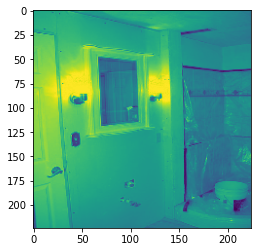

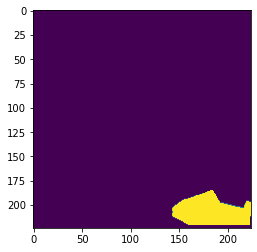

46
[ 0. 46.]


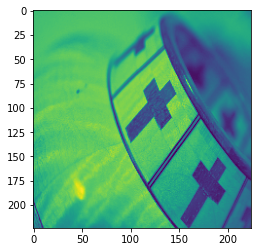

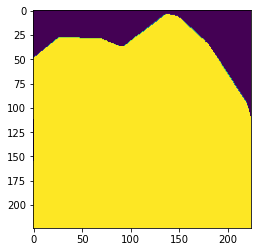

55
[ 0. 55.]


In [8]:
### Look at some example data
plt.imshow(train_dataset[0][0][0])
plt.show()
plt.imshow(train_dataset[0][1][0])
plt.show()
print(train_dataset[0][2])
print(np.unique(train_dataset[0][1]))

plt.imshow(train_dataset[8][0][0])
plt.show()
plt.imshow(train_dataset[8][1][0])
plt.show()
print(train_dataset[8][2])
print(np.unique(train_dataset[8][1]))

In [9]:
### Print dictionary of class labels
label_map

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18,
 21: 19,
 22: 20,
 23: 21,
 24: 22,
 25: 23,
 28: 24,
 32: 25,
 33: 26,
 36: 27,
 38: 28,
 40: 29,
 41: 30,
 42: 31,
 47: 32,
 48: 33,
 50: 34,
 52: 35,
 54: 36,
 55: 37,
 56: 38,
 58: 39,
 59: 40,
 60: 41,
 61: 42,
 62: 43,
 65: 44,
 67: 45,
 70: 46,
 73: 47,
 77: 48,
 78: 49,
 79: 50,
 80: 51,
 81: 52,
 82: 53,
 85: 54,
 86: 55,
 87: 56,
 88: 57,
 89: 58,
 90: 59}

### Restrict training set to have only the same classes as the validation set

In [10]:
val_classes = []
for i, (img, mask, classId) in enumerate(val_dataset):
    val_classes.append(classId)
val_classes = set(val_classes)

indices = []
for i, (image, mask, classId) in enumerate(train_dataset):
    if classId in val_classes:
        indices.append(i)
train_dataset_subset = Subset(train_dataset, indices)

### Instantiate new train_loader

In [11]:
train_dataset_subset.curr_len = len(train_dataset_subset)
train_loader = DataLoader(dataset=train_dataset_subset, batch_size=16, sampler=RandomSampler(train_dataset_subset))

### Don't run below 2 cells. They show the classes that were in train but not val

In [26]:
# mask_ids = []
# classIds = []
# for img, mask, classId in train_dataset:
#     mask_ids.extend(np.unique(mask))
#     classIds.append(classId)
# mask_ids = sorted(list(set(mask_ids)))
# classIds = sorted(list(set(classIds)))
# print(mask_ids)
# print()
# print(classIds)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 63.0, 64.0, 72.0, 74.0, 75.0, 76.0, 84.0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 72, 74, 75, 76, 84]


In [25]:
# mask_ids = []
# classIds = []
# for img, mask, classId in train_dataset_subset:
#     mask_ids.extend(np.unique(mask))
#     classIds.append(classId)
# mask_ids = sorted(list(set(mask_ids)))
# classIds = sorted(list(set(classIds)))
# print(mask_ids)
# print()
# print(classIds)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


### Helper functions for training

In [9]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for i, batch in enumerate(dataloader):
        #print(f'train batch {i}')
        if use_gpu:
            batch = [element.cuda() for element in batch]
        image, mask, classId = batch
        model.zero_grad()  # clear gradients
        seg_output, class_output = model(image.float())  # get model outputs
        seg_loss = criterion(seg_output.float(), mask.long().squeeze(1))
        class_output = class_output.squeeze(2).squeeze(2)
        class_loss = criterion(class_output.float(), classId.long())
        batch_loss = seg_loss + class_loss  # compute loss as sum of seg and class loss
        total_loss += batch_loss.item()  # add batch loss to total loss
        batch_loss.backward()  # backpropagate
        optimizer.step()  # update params

    avg_loss = total_loss / len(dataloader)  # compute average loss
    return avg_loss


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            #print(f'eval batch {i}')
            if use_gpu:
                batch = [element.cuda() for element in batch]
            image, mask, classId = batch
            seg_output, class_output = model(image.float())  # get model outputs
            class_output = class_output.squeeze(2).squeeze(2)
            seg_loss = criterion(seg_output.float(), mask.long().squeeze(1))
            class_loss = criterion(class_output.float(), classId.long())
            batch_loss = seg_loss + class_loss  # compute loss as sum of seg and class loss
            total_loss += batch_loss.item()  # add batch loss to total loss

    avg_loss = total_loss / len(dataloader)  # compute average loss
    return avg_loss


def run_training(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    best_val_loss = math.inf
    best_state_dict = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {} of {}'.format(epoch + 1, num_epochs))
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = evaluate(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/mtl_model.pt')
            best_model_state_dict = model.state_dict()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # print losses every epoch
        print('Training Loss: {}'.format(train_loss))
        print('Val Loss: {} \n'.format(val_loss))

    return best_state_dict

### Train model

In [ ]:
best_state_dict = run_training(num_epochs=10, model=mtlunet,
                               train_loader=train_loader, val_loader=val_loader,
                               optimizer=optimizer, criterion=criterion)

Epoch 1 of 10
Training Loss: 4.866791098894075
Val Loss: 1512220.2401315789 

Epoch 2 of 10
Training Loss: 4.028829443731973
Val Loss: 215552.639901889 

Epoch 3 of 10
Training Loss: 3.761502807362135
Val Loss: 7779.412067614104 

Epoch 4 of 10
Training Loss: 3.5569892176361972
Val Loss: 1942.101044102719 

Epoch 5 of 10
Training Loss: 3.404080653467844
Val Loss: 30332.525664204044 

Epoch 6 of 10
Training Loss: 3.2527831625106725
Val Loss: 55769522.37084293 

Epoch 7 of 10


### Test some predictions

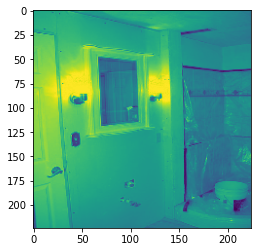

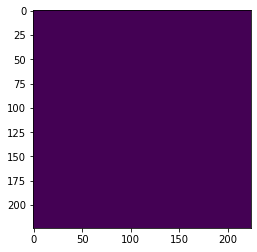

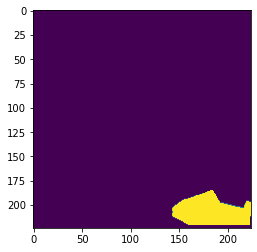

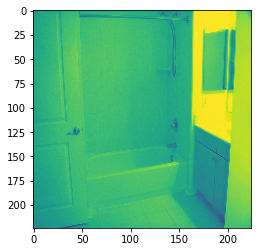

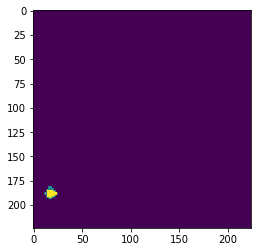

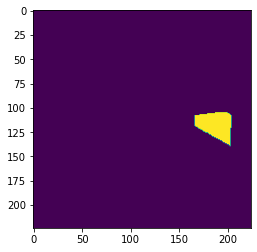

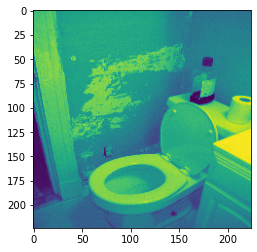

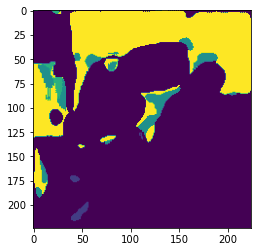

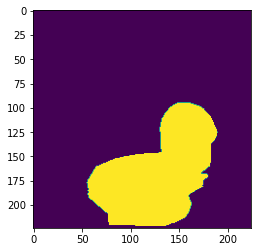

In [15]:
mtlunet = MTLUNet()
if use_gpu:
    mtlunet = mtlunet.cuda()
mtlunet.load_state_dict(torch.load('models/test_model.pt'))
mtlunet.eval()

for i in range(3):
    img = train_dataset[i][0]
    mask = train_dataset[i][1].squeeze(0)
    classId = train_dataset[i][2]
    seg_output, class_output = mtlunet(img.unsqueeze(0).float().cuda())  # get model outputs
    seg_pred = torch.argmax(seg_output, axis=1)
    class_pred = torch.argmax(class_output, axis=1)
    plt.imshow(img[0])
    plt.show()
    plt.imshow(seg_pred.squeeze(0).detach().cpu())
    plt.show()
    plt.imshow(mask.detach().cpu())
    plt.show()

In [16]:
class_pred

tensor([[[4]]], device='cuda:0')

In [ ]:
## Basic Pruning 
def prune_model(model, PRUNING_PERCENT=0.2, n=2, dims = 0):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=PRUNING_PERCENT, n=n, dim=dims)
            prune.remove(module, 'weight')
    return model

PATH = 'models/test_model.pt'
ITER_PRUNING = 10
PRUNING_PERCENT = 0.05
##Load trained model
# mtlunet = torch.load(PATH)

## placeholder for now --
mtlunet = MTLUNet()
use_gpu = False
if use_gpu:
    mtlunet = mtlunet.cuda()
# mtlunet.load_state_dict(torch.load(PATH))
mtlunet.eval()
    
for idx_prune in range(ITER_PRUNING):
        print(f"\n\nIteration {idx_prune+1} - Pruning {PRUNING_PERCENT*100}% of the least important neurons/filters...")
        dims = [0, 1, 2]
        norms = [1, 2]
        for dim in dims:
            for n in norms:
                print(f"Dimension {dim}, norms {n}") 
                model = copy.deepcopy(mtlunet)
                pruned_model = prune_model(model, PRUNING_PERCENT, n=n, dims=dim)
                      
                ## Fine-tuning
                best_state_dict = run_training(num_epochs=10, model=pruned_model,
                               train_loader=train_loader, val_loader=val_loader,
                               optimizer=optimizer, criterion=criterion)
                
                ## Testing to calculate accuracy/loss and latency
                mtlunet.eval()
                loss = evaluate(mtlunet, val_loader, criterion)
                
                img = train_dataset[i][0]
                mask = train_dataset[i][1].squeeze(0)
                classId = train_dataset[i][2]
                start = time.time()
                seg_output, class_output = mtlunet(img.unsqueeze(0).float().cuda())  # get model outputs
                seg_pred = torch.argmax(seg_output, axis=1)
                class_pred = torch.argmax(class_output, axis=1)
                end = time.time()
                inference_latency = end-start
                
                print(loss, inference_latency)
                ## Save model and update DB with accuracy/loss and latency
        PRUNING_PERCENT+=0.05
        

### Next steps for data

- ~Image data should have shape (batch_size, num_channels, height, width), but currently has shape (batch_size, height, width, num_channels): https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html~
- ~Make data generator into PyTorch dataloader object: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html~
- ~Make segmentation mask have same values as class label~
- ~Issue with the segmentation labels. There should be a single value repeating multiple times. But there are many different values within some segmentation masks (seems to be an issue with getNormalMask). Fixed.~
- Need a lookup between class label and class names to better understand the data
- ~Need the training dataset to contain the same classes as the validation dataset. Currently, there are some classes in the training dataset that are not in the validation dataset.~

### Next steps for architecture

- ~Finalize class branch~
- ~Add skip connections~
- ~Add densenet-style concatenation connections~
- ~Update forward pass~

### Next steps for training

- ~Implement combined loss~
- ~Create training loop~
- Check why val loss is so much higher than train loss. Also check that avg loss is being calculated correctly for seg loss.

### Next steps for pruning

- Implement basic pruning
- Implement task-specific pruning, specified by input task
- Implement one-shot pruning

### Scratch Work

In [ ]:
### Get number of classes
classIds = []
train_gen = data.dataGeneratorCoco(train_images, train_coco, 'dataset',
                                   input_image_size, batch_size, 'train', mask_type)
for img, mask, classId in train_gen:
    classIds.append(classId)
print(len(set(classIds)))

### Scratch

# Segmentation Only Model

In [11]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for i, batch in enumerate(dataloader):
        #print(f'train batch {i}')
        if use_gpu:
            batch = [element.cuda() for element in batch]
        image, mask, classId = batch
        model.zero_grad()  # clear gradients
        seg_output = model(image.float())  # get model outputs
        seg_loss = criterion(seg_output.float(), mask.long().squeeze(1))
        batch_loss = seg_loss
        total_loss += batch_loss.item()  # add batch loss to total loss
        batch_loss.backward()  # backpropagate
        optimizer.step()  # update params

    avg_loss = total_loss / len(dataloader)  # compute average loss
    return avg_loss


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            #print(f'eval batch {i}')
            if use_gpu:
                batch = [element.cuda() for element in batch]
            image, mask, classId = batch
            seg_output = model(image.float())  # get model outputs
            seg_loss = criterion(seg_output.float(), mask.long().squeeze(1))
            batch_loss = seg_loss
            total_loss += batch_loss.item()  # add batch loss to total loss

    avg_loss = total_loss / len(dataloader)  # compute average loss
    return avg_loss


def run_training(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    best_val_loss = math.inf
    best_state_dict = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {} of {}'.format(epoch + 1, num_epochs))
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = evaluate(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/seg_only_model.pt')
            best_model_state_dict = model.state_dict()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # print losses every epoch
        print('Training Loss: {}'.format(train_loss))
        print('Val Loss: {} \n'.format(val_loss))

    return best_state_dict

In [12]:
### Set up model, loss, and optimizer
segunet = SegOnlyUNet()
if use_gpu:
    segunet = segunet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(segunet.parameters(), lr=0.001)

In [ ]:
best_state_dict = run_training(num_epochs=10, model=segunet,
                               train_loader=train_loader, val_loader=val_loader,
                               optimizer=optimizer, criterion=criterion)

Epoch 1 of 50
Training Loss: 1.3142836702770966
Val Loss: 9570.285265169645 

Epoch 2 of 50
Training Loss: 0.999386180729367
Val Loss: 544.1607593956746 

Epoch 3 of 50
Training Loss: 0.9544776034563087
Val Loss: 2413.153806987562 

Epoch 4 of 50
Training Loss: 0.9133576759072237
Val Loss: 51405.21016010485 

Epoch 5 of 50
Training Loss: 0.8809765443552372
Val Loss: 417021221.6315789 

Epoch 6 of 50
Training Loss: 0.8514039444022401
Val Loss: 264663074.7368421 

Epoch 7 of 50
Training Loss: 0.8253969089929447
Val Loss: 878328630.7368422 

Epoch 8 of 50
Training Loss: 0.7916434044408244
Val Loss: 1093453083.7894738 

Epoch 9 of 50
Training Loss: 0.7655653570973596
Val Loss: 9876044387.368422 

Epoch 10 of 50


# Classification Only Model

In [12]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for i, batch in enumerate(dataloader):
        #print(f'train batch {i}')
        if use_gpu:
            batch = [element.cuda() for element in batch]
        image, mask, classId = batch
        model.zero_grad()  # clear gradients
        class_output = model(image.float())  # get model outputs
        class_output = class_output.squeeze(2).squeeze(2)
        class_loss = criterion(class_output.float(), classId.long())
        batch_loss = class_loss  # compute loss as sum of seg and class loss
        total_loss += batch_loss.item()  # add batch loss to total loss
        batch_loss.backward()  # backpropagate
        optimizer.step()  # update params

    avg_loss = total_loss / len(dataloader)  # compute average loss
    return avg_loss


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            #print(f'eval batch {i}')
            if use_gpu:
                batch = [element.cuda() for element in batch]
            image, mask, classId = batch
            class_output = model(image.float())  # get model outputs
            class_output = class_output.squeeze(2).squeeze(2)
            class_loss = criterion(class_output.float(), classId.long())
            batch_loss = class_loss  # compute loss as sum of seg and class loss
            total_loss += batch_loss.item()  # add batch loss to total loss

    avg_loss = total_loss / len(dataloader)  # compute average loss
    return avg_loss


def run_training(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    best_val_loss = math.inf
    best_state_dict = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {} of {}'.format(epoch + 1, num_epochs))
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = evaluate(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/class_model.pt')
            best_model_state_dict = model.state_dict()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # print losses every epoch
        print('Training Loss: {}'.format(train_loss))
        print('Val Loss: {} \n'.format(val_loss))

    return best_state_dict

In [13]:
### Set up model, loss, and optimizer
classunet = ClassOnlyUNet()
if use_gpu:
    classunet = classunet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classunet.parameters(), lr=0.001)

In [14]:
best_state_dict = run_training(num_epochs=10, model=classunet,
                               train_loader=train_loader, val_loader=val_loader,
                               optimizer=optimizer, criterion=criterion)

Epoch 1 of 10
Training Loss: 3.546380216576332
Val Loss: 4.221757361763402 

Epoch 2 of 10
Training Loss: 3.017565950127535
Val Loss: 4.447927537717317 

Epoch 3 of 10
Training Loss: 2.8053213345450025
Val Loss: 4.368054954629195 

Epoch 4 of 10
Training Loss: 2.6442163628201154
Val Loss: 4.856866591855099 

Epoch 5 of 10
Training Loss: 2.5350178241729737
Val Loss: 4.09266207720104 

Epoch 6 of 10
Training Loss: 2.4203619500925373
Val Loss: 25.76815272632398 

Epoch 7 of 10
Training Loss: 2.327944597255352
Val Loss: 23.093881770184165 

Epoch 8 of 10
Training Loss: 2.2525216916272806
Val Loss: 213.45417640083716 

Epoch 9 of 10
Training Loss: 2.14867406820142
Val Loss: 544.3135881925884 

Epoch 10 of 10
Training Loss: 2.0674201439979463
Val Loss: 3090.6584055047288 

